In [1]:
import json
import math as m

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\durga\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\durga\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
#get words after filtering stop words
def get_filtered_words(headline):
    return [word for word in word_tokenize(headline) if not word in stop_words]
# Build a vocab list from train dataset
def build_vocab_list(train_dataset):
    vocab_list = []
    for record in train_dataset:
        filtered_words = get_filtered_words(record['headline'])
        vocab_list.extend(filtered_words)
    return vocab_list

In [3]:
#create count frequency of words on training data
def build_doc_freq_dict(train_dataset,categories):
    word_frequency_dict = {category:{vocab:0 for vocab in vocab_list} for category in categories}
    for record in train_dataset:
        for word in get_filtered_words(record['headline']):
            word_frequency_dict[record['category']][word]+=1
    return word_frequency_dict


In [4]:
# seperate dataset by class 
def get_data_group_by_classes(dataset):
    seperated_category_dict = {category:[] for category in categories}
    for record in dataset:
        seperated_category_dict[record['category']].append(record)
    return seperated_category_dict

In [5]:
#checks if smoothing is needed
def is_smoothing_needed(filterd_words,word_dict,category):
    for word in filterd_words:
        if word not in word_dict[category].keys():
            return True
    return False

# get probability of the text assuming conditional independence(naive bayes)         
def get_naive_probability(category,text,word_dict,grouped_classes_dict,dataset):
    if category not in word_dict.keys():
        return
    total_word_cond_prob = 1
    smoothing_factor = 1
    filterd_words = get_filtered_words(text)
    smoothing_indicator = is_smoothing_needed(filterd_words,word_dict,category)
    for word in filterd_words:
        if not smoothing_indicator:
            total_word_cond_prob *= (word_dict[category][word]/len(grouped_classes_dict[category]))
        else:
            total_word_cond_prob *= (1/(len(grouped_classes_dict[category])+(smoothing_factor*len(grouped_classes_dict[category])))) # Smoothing technique
    class_probability = (len(grouped_classes_dict[category])/len(dataset))
    return total_word_cond_prob * class_probability
       

In [6]:
#get the predicted class given text belong to
def get_predicted_class(categories,str_to_predict,word_frequency_dict,group_classes_dict,train_dataset):
    greatest_prob = 0
    predicted_category = ''
    for category in categories:
        total_word_cond_prob = 1
        prob_of_category_contains_headline =  get_naive_probability(category,str_to_predict,word_frequency_dict,group_classes_dict,train_dataset)
        if prob_of_category_contains_headline > greatest_prob:
            greatest_prob = prob_of_category_contains_headline
            predicted_category = category
        #print(f'''prob_of_category_contains_headline {category} is {prob_of_category_contains_headline}''')
    return predicted_category

In [7]:
 #calculate the accuracy of the classifier over given dataset:
def get_accuracy(dataset,categories,word_frequency_dict,group_classes_dict):
    correct_predicted = 0
    for record in dataset: 
        predicted_category = get_predicted_class(categories,record['headline'],word_frequency_dict,group_classes_dict,dataset)
        if predicted_category == record['category']:
            correct_predicted+=1
    return correct_predicted/len(dataset)

In [8]:
def get_top_words(word_frequency_dict,category):
    sorted_list = sorted(word_frequency_dict[category].items(), key=lambda item: item[1],reverse=True)
    top_words = {word:count for word, count in sorted_list if len(word)>2}
    return top_words

In [9]:
def print_top_words(word_frequency_dict,categories):
    for category in categories:
        words = get_top_words(word_frequency_dict,category)
        wordcloud = WordCloud(width = 480, height = 480,background_color ='white',
                        min_font_size = 14)
        wordcloud.generate_from_frequencies(words)
        # plot the WordCloud image                      
        plt.figure(figsize = (6, 6))
        plt.imshow(wordcloud,interpolation="bilinear")
        plt.title(category)
        plt.axis("off")
        plt.show()

In [10]:
# Load the original dataset and do data preprocessing. 
dataset = []
categories = []
stop_words= set(stopwords.words('english'))
with open('data/News_Category_Dataset_v2.json') as data:
    for line_num,file_text in enumerate(data,start=0):
        record = json.loads(file_text)
        processed_record = {"category":record['category'],"headline":record['headline'].lower()}
        dataset.append(processed_record)
        if dataset[line_num]['category'] not in categories:
            categories.append(dataset[line_num]['category'])
no_of_records = len(dataset)
print(f""" Number of records in the dataset: {no_of_records}""")
print(f""" Number of different categories in the dataset: {len(categories)}""")


 Number of records in the dataset: 200853
 Number of different categories in the dataset: 41


In [11]:
#Peek into the dataset
df = pd.DataFrame(dataset)
df.head()

,category,headline
0,CRIME,there were 2 mass shootings in texas last week...
1,ENTERTAINMENT,will smith joins diplo and nicky jam for the 2...
2,ENTERTAINMENT,hugh grant marries for the first time at age 57
3,ENTERTAINMENT,jim carrey blasts 'castrato' adam schiff and d...
4,ENTERTAINMENT,julianna margulies uses donald trump poop bags...


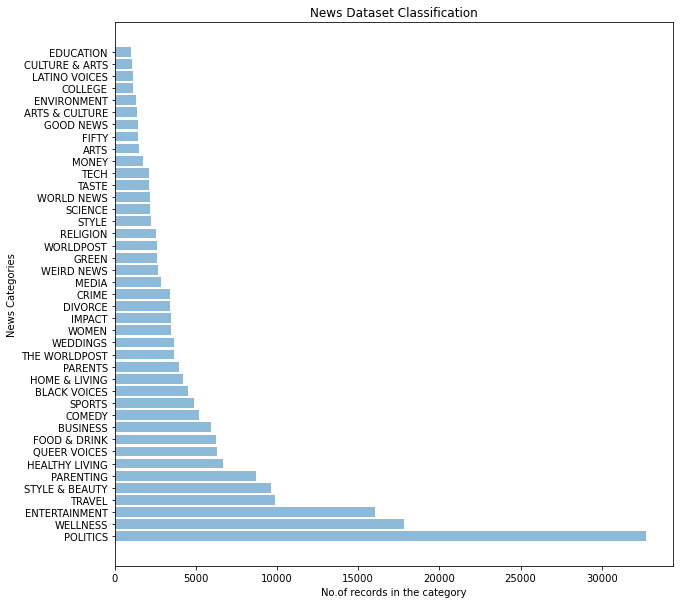

In [12]:
# plot the data distribution of all news categories in the dataset
#df.loc[:,'category'].value_counts() #to check the no of records in each category
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
ax.barh(df.loc[:,'category'].value_counts().keys(),df.loc[:,'category'].value_counts().values, alpha=0.5)
ax.set_ylabel("News Categories")
ax.set_xlabel('No.of records in the category')
ax.set_title('News Dataset Classification')
plt.show()

Iteration:1 Accuracy of the Naive Baye's Classifier over test dataset is 36.6%
Iteration:2 Accuracy of the Naive Baye's Classifier over test dataset is 36.56%
Iteration:3 Accuracy of the Naive Baye's Classifier over test dataset is 36.57%
Iteration:4 Accuracy of the Naive Baye's Classifier over test dataset is 36.81%
Iteration:5 Accuracy of the Naive Baye's Classifier over test dataset is 36.18%


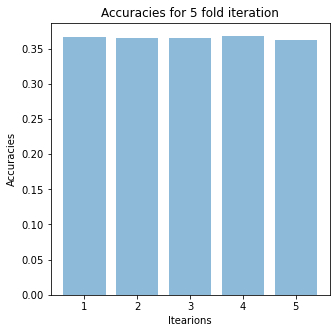

Average Accuracy of the Naive Baye's Classifier over test dataset is 36.54%


In [13]:
#Divide the dataset into train and test data
k_fold =5
accuracy_list = []
for i in range(k_fold):
    train_dataset,test_dataset = train_test_split(dataset,test_size=0.1)
    #print(f""" Number of records in the training dataset: {len(train_dataset)}""")
    #print(f""" Number of records in the test dataset: {len(test_dataset)}""")
    #Group all records with their respective category
    group_classes_dict = get_data_group_by_classes(train_dataset)
    vocab_list = build_vocab_list(train_dataset)
    word_frequency_dict = build_doc_freq_dict(train_dataset,categories)
    test_accuracy = get_accuracy(test_dataset,categories,word_frequency_dict,group_classes_dict)
    print(f'''Iteration:{i+1} Accuracy of the Naive Baye's Classifier over test dataset is {round(test_accuracy*100,2)}%''')
    accuracy_list.append(test_accuracy)
fig2, ax2 = plt.subplots()
fig2.set_figheight(5)
fig2.set_figwidth(5)
ax2.bar(np.arange(1,6),accuracy_list, alpha=0.5)
ax2.set_ylabel("Accuracies")
ax2.set_xlabel('Itearions')
ax2.set_title('Accuracies for 5 fold iteration')
plt.show()
print(f'''Average Accuracy of the Naive Baye's Classifier over test dataset is {round(np.mean(np.array(accuracy_list))*100,2)}%''')

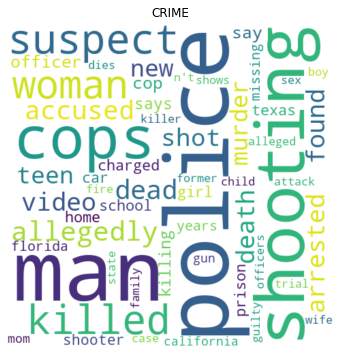

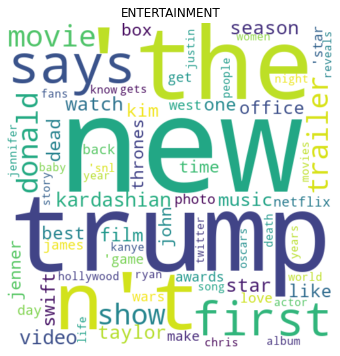

In [14]:
 print_top_words(word_frequency_dict,categories[0:2])